In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.io import fits
from scipy.ndimage import zoom
import stl

In [ ]:
def mesh_to_stl(X, Y, Z, N, file_name, unit_in='m', unit_out='mm', binary=True):
    """
    Inputs:
        X: 2D numpy array of values defining the x position of each pixel
        ie for a 1x1m sized mesh object with a 0.1m resolution we expect
        X = [[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
             [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
                                ...
             [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
             [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]]

        Y: 2D numpy array of values defining the y position of each pixel
        ie for a 1x1m sized mesh object with a 0.1m resolution we expect
        Y = [[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
             [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
                                ...
             [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
             [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]]

        Z: 2D numpy array of values defining the z position (height) of each pixel
        using plt.imshow(Z) should yeild a 'surface map' type image

        N: The number of pixels in the array, ie X, Y, Z should all be NxN

        file_name: The path/name of the file name to save under

        unit_in: The input units of the X, Y, Z arrays. Default is meters.
        Can be 'm', 'mm', 'um', 'nm'

        unit_out: The output units of the stl file. ie for a 1x1m sized mesh object
        with units in mm we expect the X, Y output to range from 0 to 900. Default
        is milimeters. Can be 'm', 'mm', 'um', 'nm'

        binary: If True file will be output as binary (smaller), else ASCII (readable)
        
    Output:
        returns None, saves an stl file to disk
    
    -------------------------------------------------------------------
    Algorithm:
        Method: Decompose the traversal pattern into a series of simpler patters
        and combine them to get the final pattern.

        For a gridsize of N, we have N-1 squares in each row/column, giving a 
        total of (N-1)^2 sqaures and 2*(N-1)^2 triangles

        Each triangle is composed of three points and a so a square is made of 6 points

        Within the series of points there is a repeating pattern which can be 
        decomposed into thee different sequences and combines

        S1: [0,0,0], [1,1,1], [1,1,1], [2,2,2], [2,2,2], [3,3,3], ... 
        S2: [0,0,1], [0,0,1], [0,0,1], [0,0,1], [0,0,1], [0,0,1], ...
        S3: [N,N,N], [0,0,0], [N,N,N], [0,0,0], [N,N,N], [0,0,0], ...
        Combining these together gives us our repeating pattern, S = S1 + S2 + S3

        Note: These brackes are there to help define the repeating sequence and
        do not relate to the final grouping into triangles.

        The final sequence is then [0, 1, S, N-1] and represents a full row of triangles
        This final sequence is then repeated again with N added to each value, then
        again with 2*N added to each value and so on.
    """
    
    # Dictionary of indexes for scaling values
    dic = {
        'm': 0,
        'mm': 1,
        'um': 2,
        'nm': 3,
    }
    
    # Array of relevant scaling values
    # X axis is unit in, Y axis is unit out
    scale_arr = [[1, 1e-3, 1e-6, 1e-9],
                 [1e3, 1, 1e-3, 1e-6],
                 [1e6, 1e3, 1, 1e-3],
                 [1e9, 1e6, 1e3, 1]]
    
    points = np.array([X.flatten(), Y.flatten(), Z.flatten()]) * scale_arr[dic[unit_out]][dic[unit_in]]

    # Other Numer of trianges and squares
    squares_per_row = N-1 
    triangles_per_row = 2 * squares_per_row
    num_squares = squares_per_row**2
    num_triangles = 2*num_squares

    # Points per triangle and square
    points_per_triangle = 3
    points_per_square = 2 * points_per_triangle

    # Number of points per row
    points_per_row = squares_per_row * points_per_square

    # Size of the sequences
    sequence_size = points_per_row - 3
    full_sequence_size = sequence_size + 3

    # Create indexes used to create sequences
    i = np.linspace(0, sequence_size, num=sequence_size, endpoint=False)
    j = np.floor_divide(i, 3)

    # Sequence 1
    S1 = np.floor_divide(j+1, 2)

    # Sequence 2
    S2_mask = (i+1)%3 == 0
    S2 = np.ones(sequence_size)*S2_mask

    # Sequence 3
    S3_mask = j%2 == 0
    S3 = N*np.ones(sequence_size)*S3_mask

    # Add together
    S = S1 + S2 + S3

    # Non repeating start and end of array
    start = np.array([0, 1])
    end = np.array([squares_per_row])

    # Combine
    sequence = np.concatenate([start, S, end])
    base_sequence = np.tile(sequence, reps=squares_per_row)

    # Create meshgrid of integer N values for the different rows
    arr_x = np.linspace(0, full_sequence_size, num=full_sequence_size, endpoint=False)
    arr_y = np.linspace(0, squares_per_row, num=squares_per_row, endpoint=False)
    X, Y = np.meshgrid(arr_x, arr_y)
    incremental_sequence = N*Y.flatten() # Flatten here in order to combine

    # Combine sequences together to create final array
    full_sequence_flat = base_sequence + incremental_sequence
    full_sequence = full_sequence_flat.reshape([num_triangles,3])

    # Force integer values
    full_sequence = np.array(full_sequence, dtype=np.int64())

    # Create the vertices and points arrays
    vertices = points.T
    faces = full_sequence

    # Create the mesh object
    grid_mesh = stl.mesh.Mesh(np.zeros(faces.shape[0], dtype=stl.mesh.Mesh.dtype))

    # input mesh vectors
    for i, f in enumerate(faces):
        for j in range(3):
            grid_mesh.vectors[i][j] = vertices[f[j],:]
            
    # Write the mesh to file
    if binary:
        grid_mesh.save('{}.stl'.format(file_name))
    else:
        grid_mesh.save('{}.stl'.format(file_name), mode=stl.Mode.ASCII)

In [2]:
def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = np.linspace(-c, c, size, endpoint=False)
    Xs, Ys = np.meshgrid(xs, xs)
    Rs = np.hypot(Xs, Ys)
    
    if radius is None:
        aperture = np.where(Rs > c, 0, np.ones([size, size]))
    else:
        aperture = np.where(Rs > radius, 0, np.ones([size, size]))
    return aperture

def get_toliman_pupil(size, path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = np.load("Toliman_pupil.npy")
    else:
        toliman_pupil = np.load("{}/Toliman_pupil.npy".format(path))
        
    phase = np.angle(toliman_pupil)
    magnitude = np.abs(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = magnitude * np.exp(1j * phase_scaled)
    return toliman_pupil_out

def phase_to_depth(comp_array, wl, n1, n2):
    """
    Converts a phase value (0, pi) to a depth for a specified wavelength
    """
    depth_array = (np.angle(comp_array) * wl) / (2 * np.pi * (n2 - n1))
    return depth_array

def generate_sinusoids(size, N, period, ampl):
    # Create meshgrid for sinusoids
    Xs = np.linspace(0, size, num=N, endpoint=False)
    X, Y = np.meshgrid(Xs, Xs)

    # Define the sine argument value to get the correct period
    B = 2*np.pi / period

    # Creating gratings
    grating = (ampl*np.sin(B*Y) + ampl*np.sin(B*X))/4
    anti_grating = (ampl*np.sin(B*Y + np.pi) + ampl*np.sin(B*X + np.pi))/4
    
    # Note here we divide the output by 4: 
    # ampl is a peak to trough value so we must halve the output once
    # To get orthogonal sine waves we sum two seperate 1D sine patterns
    # so the amplitude is doubled so we must halve again
    
    return grating, anti_grating, X, Y

---
### Define Physics paramters

In [19]:
# pupil (pattern) diameter
diameter = 20e-3 # 20mm
# diameter = 5e-3 # 5mm

# Desired pattern resolution
# resolution_in = 25e-6 # 25um
resolution_in = 10e-6 # 10um

# Calcualte number of pixels
N = np.round(diameter/resolution_in, decimals=0).astype(np.int)
resolution = diameter/N
print("True resolution is {}um".format(resolution*1e6))
print("Pattern requires {} pixels".format(N))

# Sinusoidal grating paramters
grating_amplitude = 100e-9 # 100nm
grating_period = 100e-6 # 100 microns

# Substrate and observatioanl properties
# Target wavelength where we get perfect antiphase
wl = 635e-9 # 635nm
n1 = 1 # unitless
n2 = 1.455 # unitless

True resolution is 10.0um
Pattern requires 2000 pixels


In [20]:
# Import pupil
pupil = get_toliman_pupil(N)

# # Crop for Jason
# pupil_full = get_toliman_pupil(N)
# c = pupil_full.shape[0]//2
# s = N//8
# pupil = pupil_full[c-s:c+s, c-s:c+s]

# Create masks to apply gratings
norm_phase = np.angle(pupil) == 0
anti_phase = np.angle(pupil) == np.pi

# Turn pupil into array of physical depth values
pupil_physical = phase_to_depth(pupil, wl, n1, n2)

# Get pupil support
magnitude = get_aperture(N)

# Generate sinusoidal grating
grating, anti_grating, X, Y = generate_sinusoids(diameter, N, grating_period, grating_amplitude)

In [21]:
# Combine these values into final pupil and normalise
Zraw = magnitude * (norm_phase*(pupil_physical + grating) + anti_phase*(pupil_physical + anti_grating))
Zout = Zraw
# Zshift = Zraw - np.min(Zraw)
# Znorm = Zshift/np.max(Zshift)

# 16 bit out
# Zout = ((2**16 - 1)*Znorm).astype(np.uint16)

# 8 bit out
# Zout = ((2**8 - 1)*Znorm).astype(np.uint8)

In [30]:
c = Zout.shape[0]//2
s = N//8

# For 25um
# ox = 150

# For 10um
ox = int(150*2.5)


Zout_small = Zout[c-s:c+s, c-s+ox:c+s+ox]
X_small = X[c-s:c+s, c-s+ox:c+s+ox]
Y_small = Y[c-s:c+s, c-s+ox:c+s+ox]
N_small = 2*s

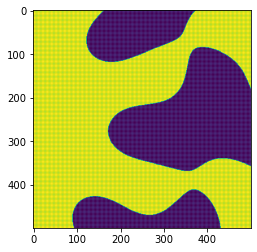

In [31]:
plt.imshow(Zout_small)

In [32]:
# # Check that Z is what we expect
# ratio = N / 800 #  / N
# size = int(ratio * 80)

# x1 = int(200 * ratio)
# y1 = int(0 * ratio)
# cut_1 = Zout[y1:y1+size, x1:x1+size]

# x2 = int(400 * ratio)
# y2 = int(400 * ratio)
# cut_2 = Zout[y2:y2+size, x2:x2+size]

# x3 = int(500 * ratio)
# y3 = int(500 * ratio)
# cut_3 = Zout[y3:y3+size, x3:x3+size]

# plt.figure(figsize=(20,16))

# ax = plt.subplot(2,2,1)
# plt.imshow(Zout)
# ax.add_patch(patches.Rectangle((x1, y1), size, size))
# ax.add_patch(patches.Rectangle((x2, y2), size, size))
# ax.add_patch(patches.Rectangle((x3, y3), size, size))
# plt.colorbar()


# plt.subplot(2,2,2)
# plt.imshow(cut_1)
# plt.colorbar()

# plt.subplot(2,2,3)
# plt.imshow(cut_2)
# plt.colorbar()

# plt.subplot(2,2,4)
# plt.imshow(cut_3)
# plt.colorbar()
# plt.show()

---

## Save files

In [33]:
unit_out = 'mm'
mesh_to_stl(X_small, Y_small, Zout_small, N_small, 'Toliman_{:.0f}_{}_small'.format(resolution*1e6, unit_out), unit_in='m', unit_out=unit_out, binary=True)

unit_out = 'um'
mesh_to_stl(X_small, Y_small, Zout_small, N_small, 'Toliman_{:.0f}_{}_small'.format(resolution*1e6, unit_out), unit_in='m', unit_out=unit_out, binary=True)